In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Khai báo các thông số
img_width, img_height = 224, 224
batch_size = 16
epochs = 10
num_classes = 3

In [4]:
# Đường dẫn đến thư mục chứa dữ liệu
data_dir = '/content/drive/MyDrive/Colab Notebooks/Experimental/rmbg_dataset/0.5'

# Danh sách các lớp (classes) là các thư mục con trong thư mục chứa dữ liệu
classes = os.listdir(data_dir)
print(classes)

['torso', 'leg', 'arm']


In [5]:
# Tạo empty lists để lưu trữ đường dẫn hình ảnh và nhãn tương ứng
image_paths = []
labels = []

# Lặp qua mỗi lớp
for class_label in classes:
  class_dir = os.path.join(data_dir, class_label)
  # Lặp qua mỗi hình ảnh trong mỗi lớp
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    image_paths.append(image_path)
    labels.append(class_label)

# Chia dữ liệu thành tập huấn luyện và tập validation
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Tạo DataFrame cho tập huấn luyện
train_dataframe = pd.DataFrame({'image_path': train_image_paths, 'label': train_labels})
# Tạo DataFrame cho tập validation
val_dataframe = pd.DataFrame({'image_path': val_image_paths, 'label': val_labels})

In [6]:
# Tạo ImageDataGenerator cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Chuẩn hóa lại giá trị pixel về khoảng [0,1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Tạo ImageDataGenerator cho tập validation, chỉ cần rescale lại giá trị pixel
val_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho tập huấn luyện
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,  # DataFrame chứa đường dẫn hình ảnh và nhãn cho tập huấn luyện
    x_col="image_path",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Tạo generator cho tập validation
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_dataframe,  # DataFrame chứa đường dẫn hình ảnh và nhãn cho tập validation
    x_col="image_path",
    y_col="label",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 84 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.


In [7]:
# Load pre-trained ResNet50 model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [8]:
# Add custom layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
# Freeze convolutional base
base_model.trainable = False

In [10]:
# Compile model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 49278851 (187.98 MB)
Trainable params: 25691139 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [11]:
# Định nghĩa callback để ghi log TensorBoard
log_dir = "/content/drive/MyDrive/Colab Notebooks/Experimental/ResNet50/logs/fit"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

Epoch 1/10
5/5 [==============================] - 12s 1s/step - loss: 20.6848 - accuracy: 0.3529 - val_loss: 18.8498 - val_accuracy: 0.3750
Epoch 2/10
5/5 [==============================] - 1s 333ms/step - loss: 9.0066 - accuracy: 0.4706 - val_loss: 0.9008 - val_accuracy: 0.7500
Epoch 3/10
5/5 [==============================] - 1s 286ms/step - loss: 2.1850 - accuracy: 0.6176 - val_loss: 1.9370 - val_accuracy: 0.6875
Epoch 4/10
5/5 [==============================] - 1s 269ms/step - loss: 2.0759 - accuracy: 0.6324 - val_loss: 1.9075 - val_accuracy: 0.8125
Epoch 5/10
5/5 [==============================] - 1s 240ms/step - loss: 1.6684 - accuracy: 0.6765 - val_loss: 0.7721 - val_accuracy: 0.7500
Epoch 6/10
5/5 [==============================] - 1s 338ms/step - loss: 1.0162 - accuracy: 0.7647 - val_loss: 1.2825 - val_accuracy: 0.8125
Epoch 7/10
5/5 [==============================] - 1s 282ms/step - loss: 0.6051 - accuracy: 0.8088 - val_loss: 0.2154 - val_accuracy: 0.8750
Epoch 8/10
5/5 [====

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 166ms/step - loss: 0.5665 - accuracy: 0.8125
Test accuracy: 0.8125


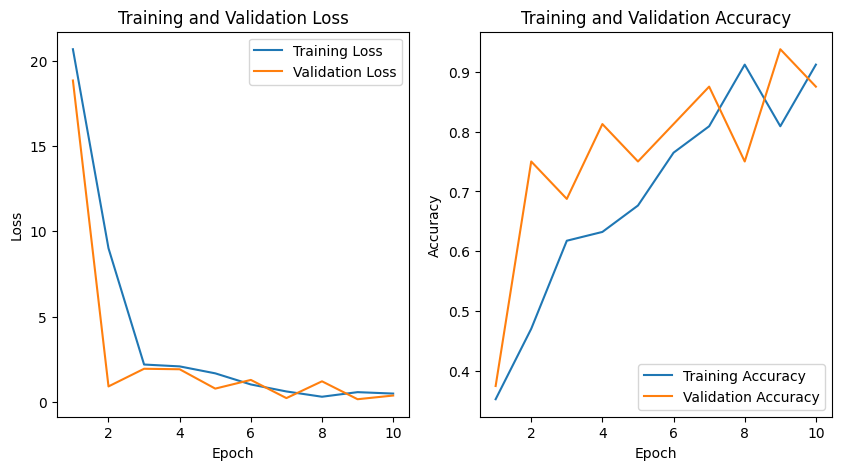

In [14]:
# Visualize loss and accuracy

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, epochs+1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()